In [33]:
import numpy as np
import torch
import softsplat
import moviepy.editor
import cv2
from torchvision import io
import matplotlib.pyplot as plt
def _flow_16bit_to_float(flow_16bit: np.ndarray):
    assert flow_16bit.dtype == np.uint16, flow_16bit.dtype
    assert flow_16bit.ndim == 3
    h, w, c = flow_16bit.shape
    assert c == 3
    # BGR 转 RGB
    flow_16bit = flow_16bit[..., ::-1]

    valid2D = flow_16bit[..., 2] == 1
    assert valid2D.shape == (h, w)

    assert np.all(flow_16bit[~valid2D, -1] == 0)
    valid_map = np.where(valid2D)
    flow_16bit = flow_16bit.astype('float32')
    flow_map = np.zeros((h, w, 2), dtype='float32')
    flow_map[valid_map[0], valid_map[1], 0] = (flow_16bit[valid_map[0], valid_map[1], 0] - 2 ** 15) / 128
    flow_map[valid_map[0], valid_map[1], 1] = (flow_16bit[valid_map[0], valid_map[1], 1] - 2 ** 15) / 128
    return flow_map, valid2D
##########################################################

def read_flo(strFile):
    flow_16bit = cv2.imread(str(strFile), cv2.IMREAD_ANYDEPTH | cv2.IMREAD_ANYCOLOR)
    strFlow, valid2D = _flow_16bit_to_float(flow_16bit)
    # assert(np.frombuffer(buffer=strFlow, dtype=np.float32, count=1, offset=0) == 202021.25)

    # intWidth = np.frombuffer(buffer=strFlow, dtype=np.int32, count=1, offset=4)[0]
    # intHeight = np.frombuffer(buffer=strFlow, dtype=np.int32, count=1, offset=8)[0]

    # return np.frombuffer(buffer=strFlow, dtype=np.float32, count=intHeight * intWidth * 2, offset=12).reshape(intHeight, intWidth, 2)
    return strFlow
# end

##########################################################

backwarp_tenGrid = {}

def backwarp(tenIn, tenFlow):
    if str(tenFlow.shape) not in backwarp_tenGrid:
        tenHor = torch.linspace(start=-1.0, end=1.0, steps=tenFlow.shape[3], dtype=tenFlow.dtype, device=tenFlow.device).view(1, 1, 1, -1).repeat(1, 1, tenFlow.shape[2], 1)
        tenVer = torch.linspace(start=-1.0, end=1.0, steps=tenFlow.shape[2], dtype=tenFlow.dtype, device=tenFlow.device).view(1, 1, -1, 1).repeat(1, 1, 1, tenFlow.shape[3])

        backwarp_tenGrid[str(tenFlow.shape)] = torch.cat([tenHor, tenVer], 1).cuda()
    # end

    tenFlow = torch.cat([tenFlow[:, 0:1, :, :] / ((tenIn.shape[3] - 1.0) / 2.0), tenFlow[:, 1:2, :, :] / ((tenIn.shape[2] - 1.0) / 2.0)], 1)

    return torch.nn.functional.grid_sample(input=tenIn, grid=(backwarp_tenGrid[str(tenFlow.shape)] + tenFlow).permute(0, 2, 3, 1), mode='bilinear', padding_mode='zeros', align_corners=True)
# end

##########################################################
filename = 'zurich_city_01_a/000181'
filename_next = 'zurich_city_01_a/000182'
flow_type = 'forward'
filename_first = f'/home/xiaoshan/work/adap_v/my_proj/data/DSEC/dsec_anytime/day/leftImg8bit/train/{filename}.png'
filename_second = f'/home/xiaoshan/work/adap_v/my_proj/data/DSEC/dsec_anytime/day/leftImg8bit_next/train/{filename_next}.png'
# filename_flow = f'/home/xiaoshan/work/adap_v/my_proj/DSEC/train/zurich_city_01_a/flow/{flow_type}/000182.png'
# tenFlow = torch.FloatTensor(np.ascontiguousarray(read_flo(filename_flow).transpose(2, 0, 1)[None, :, :, :])).cuda()
filename_flow = f'/home/xiaoshan/work/adap_v/my_proj/data/DSEC/dsec_anytime/day/flow/train/{filename}.npy'
tenFlow = torch.from_numpy(np.load(filename_flow)).unsqueeze(0).cuda()

# 1 3 H W
tenFirst = torch.FloatTensor(np.ascontiguousarray(cv2.imread(filename=filename_first, flags=-1).transpose(2, 0, 1)[None, :, :, :].astype(np.float32) * (1.0 / 255.0))).cuda()
tenSecond = torch.FloatTensor(np.ascontiguousarray(cv2.imread(filename=filename_second, flags=-1).transpose(2, 0, 1)[None, :, :, :].astype(np.float32) * (1.0 / 255.0))).cuda()
tenFirst = tenFirst[..., :440, :]
tenSecond = tenSecond[..., :440, :]
# tenFirst = io.read_image(filename_first)[:3, ...][None, :, :, :].cuda() * (1.0 / 255.0)
# tenSecond = io.read_image(filename_second)[:3, ...][None, :, :, :].cuda() * (1.0 / 255.0)
print(tenFirst.mean())
# 1 2 H W
if flow_type == 'backward':
    tenFlow = -tenFlow
tenFlow = tenFlow[..., :440, :]
print(tenFlow.shape)
print(tenFirst.shape)
# 可视化光流
flow_map = tenFlow[0].detach().cpu().numpy()
flow_magnitude = (flow_map ** 2).sum(axis=0) ** 0.5  # 计算光流的大小
plt.imshow(flow_magnitude, cmap='plasma')
# end
# 1 1 H W
tenMetric_L1 = torch.nn.functional.l1_loss(input=tenFirst, target=backwarp(tenIn=tenSecond, tenFlow=tenFlow), reduction='none').mean(1, True)
tenMetric_flow_mag = torch.sqrt(torch.square(tenFlow[:, 0, :, :] + tenFlow[:, 1, :, :])).unsqueeze(1)

# tenOutputs_L1 = [softsplat.softsplat(tenIn=tenFirst, tenFlow=tenFlow * fltTime, tenMetric=-20.0 * tenMetric_L1, strMode='soft') for fltTime in np.linspace(0.0, 1.0, 11).tolist()]
tenOutputs_L1 = [softsplat.softsplat(tenIn=tenFirst, tenFlow=tenFlow * fltTime, tenMetric=-tenMetric_L1, strMode='soft') for fltTime in np.linspace(0.0, 1.0, 11).tolist()]
npyOutputs_L1 = [(tenOutput_L1[0, :, :, :].cpu().numpy().transpose(1, 2, 0) * 255.0).clip(0.0, 255.0).astype(np.uint8) for tenOutput_L1 in tenOutputs_L1 + list(reversed(tenOutputs_L1[1:-1]))]

tenOutputs_flow_mag = [softsplat.softsplat(tenIn=tenFirst, tenFlow=tenFlow * fltTime, tenMetric=-tenMetric_flow_mag, strMode='soft') for fltTime in np.linspace(0.0, 1.0, 11).tolist()]
npyOutputs_flow_mag = [(tenOutput_flow_mag[0, :, :, :].cpu().numpy().transpose(1, 2, 0) * 255.0).clip(0.0, 255.0).astype(np.uint8) for tenOutput_flow_mag in tenOutputs_flow_mag + list(reversed(tenOutputs_flow_mag[1:-1]))]
# 两个video 串行展示
preds = [np.concatenate([npyOutputs_L1[i][:, :, ::-1], npyOutputs_flow_mag[i][:, :, ::-1]], axis=1) for i in range(len(npyOutputs_L1))]
video = moviepy.editor.ImageSequenceClip(sequence=preds, fps=15)
video.write_gif('./out.gif')
# end

# tenMetric = torch.nn.functional.l1_loss(input=tenFirst, target=backwarp(tenIn=tenSecond, tenFlow=tenFlow), reduction='none').mean([1], True)

# preds = []
# tenSummation = [softsplat.softsplat(tenIn=tenFirst, tenFlow=tenFlow * fltTime, tenMetric=None, strMode='sum') for fltTime in np.linspace(0.0, 1.0, 11).tolist()]
# tenAverage = [softsplat.softsplat(tenIn=tenFirst, tenFlow=tenFlow * fltTime, tenMetric=None, strMode='avg') for fltTime in np.linspace(0.0, 1.0, 11).tolist()]
# tenLinear = [softsplat.softsplat(tenIn=tenFirst, tenFlow=tenFlow * fltTime, tenMetric=(0.3 - tenMetric).clip(0.001, 1.0), strMode='linear') for fltTime in np.linspace(0.0, 1.0, 11).tolist()] # finding a good linearly metric is difficult, and it is not invariant to translations
# tenSoftmax = [softsplat.softsplat(tenIn=tenFirst, tenFlow=tenFlow * fltTime, tenMetric=(-20.0 * tenMetric).clip(-20.0, 20.0), strMode='soft') for fltTime in np.linspace(0.0, 1.0, 11).tolist()] # -20.0 is a hyperparameter, called 'alpha' in the paper, that could be learned using a torch.Parameter

#     # cv2.imshow(winname='summation', mat=tenSummation[0, :, :, :].cpu().numpy().transpose(1, 2, 0))
#     # cv2.imshow(winname='average', mat=tenAverage[0, :, :, :].cpu().numpy().transpose(1, 2, 0))
#     # cv2.imshow(winname='linear', mat=tenLinear[0, :, :, :].cpu().numpy().transpose(1, 2, 0))
#     # cv2.imshow(winname='softmax', mat=tenSoftmax[0, :, :, :].cpu().numpy().transpose(1, 2, 0))
#     # cv2.waitKey(delay=0)
# print(tenSummation[0].shape)
# preds = [np.concatenate([
#             tenSummation[i][:, :, ::-1].cpu().numpy().transpose(1, 2, 0) * 255.0,
#             tenAverage[i][:, :, ::-1].cpu().numpy().transpose(1, 2, 0) * 255.0,
#             tenLinear[i][:, :, ::-1].cpu().numpy().transpose(1, 2, 0) * 255.0,
#             tenSoftmax[i][:, :, ::-1].cpu().numpy().transpose(1, 2, 0) * 255.0], axis=1)
#         for i in range(len(tenSummation))]
# video = moviepy.editor.ImageSequenceClip(sequence=preds, fps=15)
# video.write_gif('./out.gif')
# end



ValueError: Cannot load file containing pickled data when allow_pickle=False

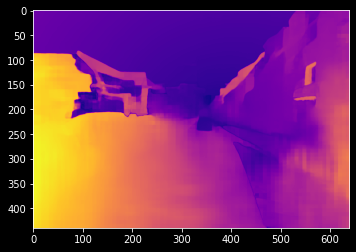

In [24]:
filename_flow = '/home/xiaoshan/work/adap_v/my_proj/data/DSEC/dsec_anytime/day/flow/val/zurich_city_13_a/000001.npy'

flow_map = np.load(filename_flow, allow_pickle=True)

flow_magnitude = (flow_map ** 2).sum(axis=0) ** 0.5

plt.imshow(flow_magnitude, cmap='plasma')

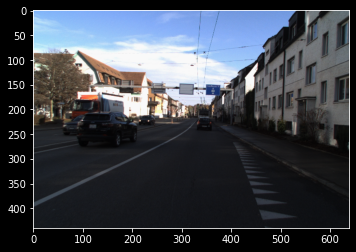

In [25]:
from torchvision import io
filename_first = '/home/xiaoshan/work/adap_v/my_proj/data/DSEC/dsec_anytime/day/leftImg8bit/val/zurich_city_13_a/000001.png'
rgb = io.read_image(filename_first)
plt.imshow(rgb.permute(1, 2, 0))
